##### Load Dataset to Pandas Dataframe

In [2]:
import pandas as pd

df__spam_dataset = pd.read_csv('spam_dataset.csv')
df__spam_dataset.head()

print(f'Dataframe shape: {df__spam_dataset.shape}')

Dataframe shape: (124075, 2)


##### Data Preprocessing

In [3]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from bs4 import BeautifulSoup
import unicodedata
from collections import Counter
import os
import warnings
import emoji
import contractions

# Suppress BeautifulSoup warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

# --- Global Configurations and NLTK Downloads ---
PREPROCESSED_FILE_PATH = 'spam_dataset_preprocessed.csv' # Reverted to previous filename

# Function to safely manage NLTK data downloads
def safe_nltk_download(resource_path, download_name):
    try:
        nltk.data.find(resource_path)
        # print(f"'{download_name}' already downloaded.") # Commented for conciseness
    except LookupError:
        print(f"Downloading '{download_name}'...")
        nltk.download(download_name)
    except Exception as e:
        print(f"An error occurred checking/downloading '{download_name}': {e}")

# Download essential NLTK data packages
print("Checking/Downloading NLTK resources...")
safe_nltk_download('tokenizers/punkt', 'punkt')
safe_nltk_download('corpora/stopwords', 'stopwords')
safe_nltk_download('corpora/wordnet', 'wordnet')
safe_nltk_download('corpora/omw-1.4', 'omw-1.4') # Dependency for WordNet

# Initialize NLTK components globally for efficiency
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
EMOTICON_PATTERN = re.compile(r'(?:[:;=X][-o*]?[DPpS\|/\)\(])|(?:\<3)') # Regex for common emoticons
RARE_WORD_THRESHOLD = 5 # Threshold for rare word filtering

# --- Core Text Preprocessing Function ---
def preprocess_text_for_fasttext(text):
    """Applies a series of text cleaning and normalization steps."""
    if not isinstance(text, str): # Handle non-string inputs, common for NA values
        return ""

    # 1. HTML tag removal
    text = BeautifulSoup(text, 'html.parser').get_text()
    # 2. Emoji to text conversion
    text = emoji.demojize(text, delimiters=(" ", " "))
    # 3. Emoticon replacement
    text = EMOTICON_PATTERN.sub(r' EMOTICON ', text)
    # 4. Convert to lowercase
    text = text.lower()
    # 5. Expand contractions
    text = contractions.fix(text)
    # 6. URL removal
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # 7. Unicode normalization and non-ASCII removal
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    # 8. Consolidate whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # 9. Punctuation removal
    text = text.translate(str.maketrans('', '', string.punctuation))
    # 10. Digit removal
    text = re.sub(r'\d+', '', text)

    # 11. Tokenization
    tokens = word_tokenize(text)

    # 12. Stop word removal and Lemmatization
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(cleaned_tokens) # FastText often uses space-separated tokens


# --- Functions for Preprocessing Pipeline Stages ---

def perform_initial_data_checks(df):
    """Displays initial DataFrame info and checks for missing values/duplicates."""
    print("--- Initial Data Checks ---")
    print(df.info(verbose=False, show_counts=True)) # Use verbose=False for conciseness
    print("\nMissing values:\n", df.isnull().sum().loc[['text', 'label']])
    print("\nOriginal label distribution:\n", df['label'].value_counts())
    return df

def handle_missing_and_duplicate_values(df):
    """Handles missing 'text'/'label' values and duplicate text entries."""
    initial_rows = df.shape[0]
    df.dropna(subset=['text', 'label'], inplace=True)
    if df.shape[0] < initial_rows:
        print(f"Dropped {initial_rows - df.shape[0]} rows due to missing 'text' or 'label'. 🗑️")

    initial_rows = df.shape[0]
    df.drop_duplicates(subset=['text'], inplace=True)
    if df.shape[0] < initial_rows:
        print(f"Removed {initial_rows - df.shape[0]} duplicate text entries. 🗑️")
    else:
        print("No duplicate text entries found. ✅")

    print(f"DataFrame shape after NA and duplicate removal: {df.shape}")
    return df

def apply_text_normalization_pipeline(df):
    """Applies text cleaning, tokenization, and rare word filtering."""
    print("\n--- Applying Text Normalization & Filtering ---")
    df['cleaned_text'] = df['text'].apply(preprocess_text_for_fasttext)

    # Rare word filtering
    all_words = []
    for text in df['cleaned_text']:
        all_words.extend(text.split())
    word_counts = Counter(all_words)
    rare_words = {word for word, count in word_counts.items() if count < RARE_WORD_THRESHOLD}
    print(f"Identified {len(rare_words)} rare words (appearing less than {RARE_WORD_THRESHOLD} times).")

    df['cleaned_text'] = df['cleaned_text'].apply(
        lambda text: ' '.join([word for word in text.split() if word not in rare_words])
    )

    # Handle rows where 'cleaned_text' might become empty after processing
    initial_rows = df.shape[0]
    df['cleaned_text'].replace('', pd.NA, inplace=True) # Use pd.NA for better handling
    df.dropna(subset=['cleaned_text'], inplace=True)
    if df.shape[0] < initial_rows:
        print(f"Dropped {initial_rows - df.shape[0]} rows with empty 'cleaned_text' after processing. 🗑️")
    else:
        print("No rows with empty 'cleaned_text' after processing. ✅")

    # Optional: Spelling correction note (still applicable)
    print("\nNote: Spelling correction is an optional, computationally intensive step, not included by default.")
    return df

def apply_label_encoding_and_fasttext_format(df):
    """Encodes labels and prepares a FastText-specific label format."""
    le = LabelEncoder()
    df['label_encoded'] = le.fit_transform(df['label'])
    label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"\n--- Applying Label Encoding ---")
    print(f"Label mapping: {label_mapping} 🏷️")

    # For supervised FastText tasks, you might want a column like this:
    df['fasttext_label_format'] = df['label'].apply(lambda x: f"__label__{x}")
    print("\nAdded 'fasttext_label_format' column for direct FastText supervised training if needed.")
    return df

# --- Main Execution Logic ---
if os.path.exists(PREPROCESSED_FILE_PATH):
    print(f"--- Loading preprocessed data from {PREPROCESSED_FILE_PATH} ---")
    df__spam_dataset = pd.read_csv(PREPROCESSED_FILE_PATH)
    print("Preprocessed data loaded successfully. ✅")
    print(f"DataFrame shape: {df__spam_dataset.shape}")
    print("Columns available:", df__spam_dataset.columns.tolist())
    print("Sample data:\n", df__spam_dataset[['text', 'cleaned_text', 'label', 'label_encoded']].head())

else:
    try:
        # Assumes df__spam_dataset is loaded from 'spam_dataset.csv' in a preceding cell.
        # If not, uncomment the line below for standalone testing (ensure 'spam_dataset.csv' exists).
        # df__spam_dataset = pd.read_csv('spam_dataset.csv')
        _ = df__spam_dataset.head()
        print("--- Preprocessed file not found. Starting preprocessing on existing df__spam_dataset. ---")
    except NameError:
        print("Error: 'df__spam_dataset' is not defined. Please load your raw dataset first. ❌")
        raise # Stop execution if the DataFrame isn't available.

    df__spam_dataset = perform_initial_data_checks(df__spam_dataset)
    df__spam_dataset = handle_missing_and_duplicate_values(df__spam_dataset)
    df__spam_dataset = apply_text_normalization_pipeline(df__spam_dataset)
    df__spam_dataset = apply_label_encoding_and_fasttext_format(df__spam_dataset)

    print("\n--- FastText Preprocessing Complete! 🎉 ---")
    print(f"Final DataFrame shape: {df__spam_dataset.shape}")
    print("Sample of DataFrame after preprocessing:\n", df__spam_dataset[['text', 'cleaned_text', 'label', 'label_encoded', 'fasttext_label_format']].head())
    print("\nFinal label distribution (encoded):\n", df__spam_dataset['label_encoded'].value_counts())

    print(f"\n--- Saving preprocessed data to {PREPROCESSED_FILE_PATH} ---")
    try:
        df__spam_dataset.to_csv(PREPROCESSED_FILE_PATH, index=False)
        print("Preprocessed data saved successfully for faster future loading. 💾")
    except Exception as e:
        print(f"Error saving preprocessed data: {e} ❌")

Checking/Downloading NLTK resources...


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NETSTACK\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NETSTACK\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\NETSTACK\AppData\Roaming\nltk_data...


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\NETSTACK\AppData\Roaming\nltk_data...


--- Loading preprocessed data from spam_dataset_preprocessed.csv ---
Preprocessed data loaded successfully. ✅
DataFrame shape: (92402, 4)
Columns available: ['label', 'text', 'cleaned_text', 'label_encoded']
Sample data:
                                                 text  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                        cleaned_text label  label_encoded  
0  go point crazy available bugis n great world l...   ham              0  
1                            ok lar joking wif u oni   ham              0  
2  free entry wkly comp win fa cup final st may t...  spam              1  
3                u dun say early hor u c already say   ham              0  
4                nah think go usf life around though   ham   

##### Feature Extraction

In [4]:
import pandas as pd
from gensim.models import FastText
import numpy as np
import os
import joblib
import logging

# --- Define File Paths ---
PREPROCESSED_FILE_PATH = 'spam_dataset_preprocessed.csv'
FEATURE_EXTRACTION_DIR = 'feature_extraction_models'
FASTTEXT_MODEL_PATH = os.path.join(FEATURE_EXTRACTION_DIR, 'gensim_fasttext_model.bin')
FASTTEXT_VECTORS_PATH = os.path.join(FEATURE_EXTRACTION_DIR, 'gensim_fasttext_feature_vectors.joblib')

# Ensure the feature extraction directory exists
os.makedirs(FEATURE_EXTRACTION_DIR, exist_ok=True)

# --- Configuration for FastText Model Training ---
FASTTEXT_VECTOR_SIZE = 300
FASTTEXT_WINDOW = 5
FASTTEXT_MIN_COUNT = 1
FASTTEXT_SG = 1
FASTTEXT_EPOCHS = 20
FASTTEXT_WORKERS = os.cpu_count()

# --- Flag to control FastText training logging verbosity ---
ENABLE_FASTTEXT_LOGGING = True # Set to True to enable logging, False to disable

print(f"FastText configuration: Vector Size={FASTTEXT_VECTOR_SIZE}, Epochs={FASTTEXT_EPOCHS}, Workers={FASTTEXT_WORKERS}...")

# --- Load Preprocessed Data ---
print("\n--- Loading Preprocessed Data for FastText ---")
try:
    df = pd.read_csv(PREPROCESSED_FILE_PATH)
    print(f"Preprocessed data loaded from {PREPROCESSED_FILE_PATH} ✅")
    print(f"DataFrame shape: {df.shape}")

    if 'cleaned_text' not in df.columns:
        raise ValueError("Error: 'cleaned_text' column not found in the preprocessed data. Please ensure text preprocessing was successful. ❌")

    initial_rows = df.shape[0]
    df.dropna(subset=['cleaned_text'], inplace=True)
    if df.shape[0] < initial_rows:
        print(f"Dropped {initial_rows - df.shape[0]} rows due to empty 'cleaned_text' for FastText processing. 🗑️")

    corpus = [text.split() for text in df['cleaned_text'].astype(str)]

    if not corpus:
        raise ValueError("Corpus is empty after loading and cleaning. Cannot train FastText model. ❌")

    print(f"Corpus prepared for FastText training: {len(corpus)} documents. Sample first document (first 5 tokens): {corpus[0][:5]}... ✅")

except FileNotFoundError:
    print(f"Error: Preprocessed data not found at {PREPROCESSED_FILE_PATH}. Please run the data preprocessing step first. ❌")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during data loading or corpus preparation: {e} ❌")
    exit()

# --- Configure logging for Gensim models based on the flag ---
if ENABLE_FASTTEXT_LOGGING:
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    print("\nLogging enabled for FastText training progress.")
else:
    # Set gensim's logger to a higher level (e.g., WARNING) to suppress INFO messages
    logging.getLogger('gensim').setLevel(logging.WARNING)
    print("\nFastText training logging is DISABLED.")


# --- Conditional FastText Model Training or Loading ---
if os.path.exists(FASTTEXT_MODEL_PATH):
    print(f"\n--- Loading pre-trained FastText Model from {FASTTEXT_MODEL_PATH} ---")
    try:
        fasttext_model = FastText.load(FASTTEXT_MODEL_PATH)
        print("FastText model loaded successfully. ✅")
    except Exception as e:
        print(f"Error loading FastText model: {e}. Attempting to re-train. ⚠️")
        # If loading fails, fall back to training
        os.remove(FASTTEXT_MODEL_PATH) # Remove corrupted/unreadable file
        # Proceed to the 'else' block
        
        # --- Train FastText Model ---
        print("\n--- Training FastText Model (this may take a moment) ---")
        fasttext_model = FastText(
            vector_size=FASTTEXT_VECTOR_SIZE,
            window=FASTTEXT_WINDOW,
            min_count=FASTTEXT_MIN_COUNT,
            sg=FASTTEXT_SG,
            workers=FASTTEXT_WORKERS
        )
        fasttext_model.build_vocab(corpus_iterable=corpus)
        fasttext_model.train(
            corpus_iterable=corpus,
            total_examples=fasttext_model.corpus_count,
            epochs=FASTTEXT_EPOCHS
        )
        print("FastText model training complete! ✅")

        # --- Save Trained FastText Model ---
        try:
            fasttext_model.save(FASTTEXT_MODEL_PATH)
            print(f"Trained FastText model saved to: {FASTTEXT_MODEL_PATH} 💾")
        except Exception as e:
            print(f"Error saving FastText model after re-training: {e} ❌")
            exit() # Exit if we can't save even after re-training
else:
    # --- Train FastText Model ---
    print("\n--- Training FastText Model (this may take a moment) ---")
    fasttext_model = FastText(
        vector_size=FASTTEXT_VECTOR_SIZE,
        window=FASTTEXT_WINDOW,
        min_count=FASTTEXT_MIN_COUNT,
        sg=FASTTEXT_SG,
        workers=FASTTEXT_WORKERS
    )
    fasttext_model.build_vocab(corpus_iterable=corpus)
    fasttext_model.train(
        corpus_iterable=corpus,
        total_examples=fasttext_model.corpus_count,
        epochs=FASTTEXT_EPOCHS
    )
    print("FastText model training complete! ✅")

    # --- Save Trained FastText Model ---
    try:
        fasttext_model.save(FASTTEXT_MODEL_PATH)
        print(f"Trained FastText model saved to: {FASTTEXT_MODEL_PATH} 💾")
    except Exception as e:
        print(f"Error saving FastText model: {e} ❌")
        exit() # Exit if we can't save the newly trained model

# --- Generate FastText Feature Vectors for each Text Entry ---
print("\n--- Generating FastText Feature Vectors ---")
fasttext_feature_vectors = np.array([fasttext_model.wv.get_sentence_vector(doc) for doc in corpus])

print(f"Generated FastText feature vectors shape: {fasttext_feature_vectors.shape} ✅")

# --- Save Feature Vectors ---
try:
    joblib.dump(fasttext_feature_vectors, FASTTEXT_VECTORS_PATH)
    print(f"FastText feature vectors saved to: {FASTTEXT_VECTORS_PATH} 💾")
except Exception as e:
    print(f"Error saving FastText feature vectors: {e} ❌")

print("\nFastText Feature Extraction Complete! 🎉")

FastText configuration: Vector Size=300, Epochs=20, Workers=12...

--- Loading Preprocessed Data for FastText ---
Preprocessed data loaded from spam_dataset_preprocessed.csv ✅
DataFrame shape: (92402, 4)
Dropped 31 rows due to empty 'cleaned_text' for FastText processing. 🗑️


2025-07-29 18:45:07,282 : INFO : loading FastText object from feature_extraction_models\gensim_fasttext_model.bin
2025-07-29 18:45:07,350 : INFO : loading wv recursively from feature_extraction_models\gensim_fasttext_model.bin.wv.* with mmap=None
2025-07-29 18:45:07,352 : INFO : loading vectors_vocab from feature_extraction_models\gensim_fasttext_model.bin.wv.vectors_vocab.npy with mmap=None


Corpus prepared for FastText training: 92371 documents. Sample first document (first 5 tokens): ['go', 'point', 'crazy', 'available', 'bugis']... ✅

Logging enabled for FastText training progress.

--- Loading pre-trained FastText Model from feature_extraction_models\gensim_fasttext_model.bin ---


2025-07-29 18:45:07,511 : INFO : loading vectors_ngrams from feature_extraction_models\gensim_fasttext_model.bin.wv.vectors_ngrams.npy with mmap=None
2025-07-29 18:45:10,618 : INFO : setting ignored attribute vectors to None
2025-07-29 18:45:10,618 : INFO : setting ignored attribute buckets_word to None
2025-07-29 18:45:26,127 : INFO : loading syn1neg from feature_extraction_models\gensim_fasttext_model.bin.syn1neg.npy with mmap=None
2025-07-29 18:45:26,295 : INFO : setting ignored attribute cum_table to None
2025-07-29 18:45:27,301 : INFO : FastText lifecycle event {'fname': 'feature_extraction_models\\gensim_fasttext_model.bin', 'datetime': '2025-07-29T18:45:27.301937', 'gensim': '4.3.3', 'python': '3.10.18 | packaged by conda-forge | (main, Jun  4 2025, 14:42:04) [MSC v.1943 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'loaded'}


FastText model loaded successfully. ✅

--- Generating FastText Feature Vectors ---
Generated FastText feature vectors shape: (92371, 300) ✅
FastText feature vectors saved to: feature_extraction_models\gensim_fasttext_feature_vectors.joblib 💾

FastText Feature Extraction Complete! 🎉


##### Train Test Eval Split

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import joblib # For loading feature vectors
import os
import torch
from torch.utils.data import TensorDataset, DataLoader

# --- Define File Paths ---
PREPROCESSED_FILE_PATH = 'spam_dataset_preprocessed.csv'
FEATURE_EXTRACTION_DIR = 'feature_extraction_models'
FASTTEXT_VECTORS_PATH = os.path.join(FEATURE_EXTRACTION_DIR, 'gensim_fasttext_feature_vectors.joblib')

# --- Load Data ---
print("--- Loading preprocessed data and FastText feature vectors for splitting ---")
try:
    df = pd.read_csv(PREPROCESSED_FILE_PATH)
    fasttext_feature_vectors = joblib.load(FASTTEXT_VECTORS_PATH)

    if 'label_encoded' not in df.columns:
        raise ValueError("Error: 'label_encoded' column not found in the preprocessed data. Ensure labels were encoded. ❌")

    # Ensure the number of feature vectors matches the number of rows in the DataFrame
    # after any potential drops during preprocessing (e.g., empty 'cleaned_text').
    initial_df_rows = df.shape[0]
    df.dropna(subset=['cleaned_text'], inplace=True) # Re-apply dropna to align with corpus used for FastText
    if df.shape[0] != initial_df_rows:
        print(f"Adjusted DataFrame by dropping {initial_df_rows - df.shape[0]} rows due to empty 'cleaned_text' to match feature vectors. ⚠️")

    if fasttext_feature_vectors.shape[0] != df.shape[0]:
        raise ValueError(
            f"Mismatch between number of feature vectors ({fasttext_feature_vectors.shape[0]}) "
            f"and number of DataFrame rows ({df.shape[0]}) after alignment. "
            "Ensure the data used for FastText training and this split are perfectly aligned. ❌"
        )
    
    X_np = fasttext_feature_vectors # Our features, keeping as NumPy for sklearn split
    y_np = df['label_encoded'].values # Our target labels, keeping as NumPy for sklearn split

    print(f"Features (X_np) shape: {X_np.shape}")
    print(f"Labels (y_np) shape: {y_np.shape}")
    print("Data loaded successfully. ✅")

except FileNotFoundError as e:
    print(f"Error loading files: {e}. Ensure both '{PREPROCESSED_FILE_PATH}' and '{FASTTEXT_VECTORS_PATH}' exist. ❌")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during data loading: {e} ❌")
    exit()

# --- Dataset Splitting (using sklearn on NumPy arrays for stratification) ---
RANDOM_SEED = 42 # For reproducibility
TEST_SIZE_INITIAL = 0.3 # 30% for combined test+evaluation
TEST_SIZE_FINAL_EVAL = 0.5 # 50% of the combined test+evaluation for evaluation

print("\n--- Splitting Dataset ---")

# Step 1: Split into training and (test + evaluation) sets
# X_train_full_np: 70% of data
# X_test_eval_np:  30% of data
X_train_full_np, X_test_eval_np, y_train_full_np, y_test_eval_np = train_test_split(
    X_np, y_np, test_size=TEST_SIZE_INITIAL, random_state=RANDOM_SEED, stratify=y_np
)
print(f"After initial split (train/test_eval):")
print(f"  Training set shape: X={X_train_full_np.shape}, y={y_train_full_np.shape}")
print(f"  Test+Evaluation set shape: X={X_test_eval_np.shape}, y={y_test_eval_np.shape}")

# Step 2: Split the (test + evaluation) set into evaluation and test sets
# X_eval_np:  50% of X_test_eval_np (which is 15% of original data)
# X_test_np: 50% of X_test_eval_np (which is 15% of original data)
X_eval_np, X_test_np, y_eval_np, y_test_np = train_test_split(
    X_test_eval_np, y_test_eval_np, test_size=TEST_SIZE_FINAL_EVAL, random_state=RANDOM_SEED, stratify=y_test_eval_np
)
print(f"\nAfter second split (eval/test from test_eval):")
print(f"  Evaluation set shape: X={X_eval_np.shape}, y={y_eval_np.shape}")
print(f"  Test set shape: X={X_test_np.shape}, y={y_test_np.shape}")

# Verify final distribution (optional, but good for sanity check)
print("\nFinal dataset sizes:")
print(f"  Train: {X_train_full_np.shape[0]} samples ({X_train_full_np.shape[0]/X_np.shape[0]:.2%})")
print(f"  Evaluation: {X_eval_np.shape[0]} samples ({X_eval_np.shape[0]/X_np.shape[0]:.2%})")
print(f"  Test: {X_test_np.shape[0]} samples ({X_test_np.shape[0]/X_np.shape[0]:.2%})")

# --- Convert Split NumPy arrays to PyTorch Tensors ---
# Crucially, NO RESHAPING here. Keep features as (N, 300).
# Labels for binary classification (BCELoss/BCEWithLogitsLoss) should be float32 and unsqueezed to (batch_size, 1).
X_train = torch.tensor(X_train_full_np, dtype=torch.float32)
y_train = torch.tensor(y_train_full_np, dtype=torch.float32).unsqueeze(1) # Add dimension for labels (N, 1)

X_eval = torch.tensor(X_eval_np, dtype=torch.float32)
y_eval = torch.tensor(y_eval_np, dtype=torch.float32).unsqueeze(1)

X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1)

# --- Create PyTorch TensorDatasets ---
train_dataset = TensorDataset(X_train, y_train)
eval_dataset = TensorDataset(X_eval, y_eval) # Consistent naming: eval_dataset
test_dataset = TensorDataset(X_test, y_test)

print(f"\nPyTorch TensorDataset Shapes (features remain 1D vectors):")
print(f"Train Dataset X shape: {train_dataset.tensors[0].shape}, Y shape: {train_dataset.tensors[1].shape}")
print(f"Evaluation Dataset X shape: {eval_dataset.tensors[0].shape}, Y shape: {eval_dataset.tensors[1].shape}")
print(f"Test Dataset X shape: {test_dataset.tensors[0].shape}, Y shape: {test_dataset.tensors[1].shape}")

# --- Create PyTorch DataLoaders ---
BATCH_SIZE = 32 # You can adjust this based on your XPU's memory

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(dataset=eval_dataset, batch_size=BATCH_SIZE, shuffle=False) # Consistent naming: eval_loader
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nPyTorch DataLoaders Created with Batch Size: {BATCH_SIZE} ✅")
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in eval_loader: {len(eval_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

print("\nData splitting into PyTorch Tensors and DataLoaders complete (XPU/IPEX Ready for MLP). ✅")

--- Loading preprocessed data and FastText feature vectors for splitting ---
Adjusted DataFrame by dropping 31 rows due to empty 'cleaned_text' to match feature vectors. ⚠️
Features (X_np) shape: (92371, 300)
Labels (y_np) shape: (92371,)
Data loaded successfully. ✅

--- Splitting Dataset ---
After initial split (train/test_eval):
  Training set shape: X=(64659, 300), y=(64659,)
  Test+Evaluation set shape: X=(27712, 300), y=(27712,)

After second split (eval/test from test_eval):
  Evaluation set shape: X=(13856, 300), y=(13856,)
  Test set shape: X=(13856, 300), y=(13856,)

Final dataset sizes:
  Train: 64659 samples (70.00%)
  Evaluation: 13856 samples (15.00%)
  Test: 13856 samples (15.00%)

PyTorch TensorDataset Shapes (features remain 1D vectors):
Train Dataset X shape: torch.Size([64659, 300]), Y shape: torch.Size([64659, 1])
Evaluation Dataset X shape: torch.Size([13856, 300]), Y shape: torch.Size([13856, 1])
Test Dataset X shape: torch.Size([13856, 300]), Y shape: torch.Size([

##### Model Building

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch

# --- Intel Extension for PyTorch (IPEX) and Device Configuration ---
try:
    import intel_extension_for_pytorch as ipex
    _IPEX_AVAILABLE = True
except ImportError:
    _IPEX_AVAILABLE = False
    print("Warning: intel_extension_for_pytorch not found. XPU acceleration will not be available.")

# Device selection priority: Intel XPU > CUDA > CPU
if _IPEX_AVAILABLE and hasattr(torch, 'xpu') and torch.xpu.is_available():
    device = torch.device("xpu")
    print(f"Intel Extension for PyTorch (IPEX) imported. Using Intel XPU (GPU) for training. Device: {device} 🚀")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"NVIDIA CUDA GPU is available. Using CUDA for training. Device: {device} ⚡")
else:
    device = torch.device("cpu")
    print("No GPU available (Intel XPU or CUDA). Falling back to CPU. ⚠️")


# --- Define the Bidirectional LSTM (BiLSTM) Classifier Model ---
class BiLSTMSpamClassifier(nn.Module):
    def __init__(self, input_dim=300, lstm_input_size=1, hidden_size=128, num_layers=2, dropout_rate=0.5, num_classes=1):
        """
        Initializes the Bidirectional LSTM (BiLSTM) model for spam classification.

        Args:
            input_dim (int): The dimensionality of the flat input feature vector (e.g., 300 for FastText).
                             This will be reshaped to become the sequence length for the LSTM.
            lstm_input_size (int): The feature dimension of each element in the sequence.
                                   Since we reshape a 300D vector to (300, 1), this is 1.
            hidden_size (int): The number of features in the hidden state (h) of the LSTM.
            num_layers (int): Number of recurrent layers.
            dropout_rate (float): Dropout rate for regularization applied to the output of each LSTM layer
                                  except the last (if num_layers > 1).
            num_classes (int): The number of output classes. For binary classification (spam/ham), this is 1.
        """
        super(BiLSTMSpamClassifier, self).__init__()

        self.input_dim = input_dim # The original flat dimension (e.g., 300)
        self.lstm_input_size = lstm_input_size # Feature size per time step (e.g., 1)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 # Because it's bidirectional
        self.num_classes = num_classes

        # Bidirectional LSTM layer
        # batch_first=True means input/output tensors are (batch, seq_len, feature)
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True, # Make it bidirectional
            dropout=(dropout_rate if num_layers > 1 else 0) # Apply dropout if more than one layer
        )

        # Fully connected layer after LSTM
        # The input to this FC layer will be the concatenated hidden states from the last layer
        # of the BiLSTM (forward and backward).
        # For sequence classification, we typically take the last hidden state.
        # Output size from BiLSTM: num_directions * hidden_size
        # We also multiply by num_layers if we concatenate the hidden states from all layers,
        # but for simple classification, the last layer's final hidden state is common.
        # Here, we'll take the final hidden state (h_n) from the LSTM.
        # h_n shape: (num_layers * num_directions, batch, hidden_size)
        # We need to extract the last layer's hidden state and flatten it.
        self.fc = nn.Linear(self.num_directions * hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid() # Sigmoid for binary classification probabilities

    def forward(self, x):
        """
        Defines the forward pass of the BiLSTM model.

        Args:
            x (torch.Tensor): The input tensor, expected shape (batch_size, input_dim).

        Returns:
            torch.Tensor: The predicted probabilities of the positive class (spam), shape (batch_size, 1).
        """
        # Reshape input for LSTM: (batch_size, seq_len, input_size)
        # We treat the 300 features as a sequence of 300 elements, each with a feature size of 1.
        # Input x shape: (batch_size, 300)
        # Reshaped x shape: (batch_size, 300, 1)
        x = x.view(x.size(0), self.input_dim, self.lstm_input_size)

        # Pass through LSTM layer
        # output: (batch_size, seq_len, num_directions * hidden_size)
        # h_n: (num_layers * num_directions, batch_size, hidden_size) - final hidden state
        # c_n: (num_layers * num_directions, batch_size, hidden_size) - final cell state
        output, (h_n, c_n) = self.lstm(x)

        # For classification, we typically use the final hidden state.
        # For a bidirectional LSTM, h_n contains the hidden states from the last layer
        # for both forward and backward directions.
        # Shape of h_n: (num_layers * num_directions, batch_size, hidden_size)
        # We want the hidden state from the last layer (num_layers - 1).
        # For bidir, the last layer's forward state is h_n[-2, :, :] and backward is h_n[-1, :, :]
        # Concatenate them:
        final_hidden_state = torch.cat((h_n[-2, :, :], h_n[-1, :, :]), dim=1)
        # Shape: (batch_size, num_directions * hidden_size)

        # Pass through the fully connected layer
        logits = self.fc(final_hidden_state)
        probabilities = self.sigmoid(logits)

        return probabilities, logits # Return both probabilities and raw logits


# --- Instantiate the BiLSTM Spam Classifier Model ---
INPUT_DIM_FLAT = 300 # FastText feature vector size
LSTM_INPUT_FEATURE_SIZE = 1 # Each element in the 300-length sequence has 1 feature
LSTM_HIDDEN_SIZE = 128
LSTM_NUM_LAYERS = 2
DROPOUT_RATE = 0.5
NUM_CLASSES_PROBLEM = 1 # For binary classification (spam/ham)

print("\n--- Building Bidirectional LSTM Spam Classifier Model (PyTorch) ---")
model = BiLSTMSpamClassifier(
    input_dim=INPUT_DIM_FLAT,
    lstm_input_size=LSTM_INPUT_FEATURE_SIZE,
    hidden_size=LSTM_HIDDEN_SIZE,
    num_layers=LSTM_NUM_LAYERS,
    dropout_rate=DROPOUT_RATE,
    num_classes=NUM_CLASSES_PROBLEM
)

# Move the model to the determined device (XPU/CPU)
model.to(device)

# Print the model's structure to verify
print("\n--- Model Architecture ---")
print(model)

# Calculate and print the number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_params:,}")
print("\nPyTorch Bidirectional LSTM Classifier Model Building Complete (XPU/IPEX Ready). 🎉")

NVIDIA CUDA GPU is available. Using CUDA for training. Device: cuda ⚡

--- Building Bidirectional LSTM Spam Classifier Model (PyTorch) ---

--- Model Architecture ---
BiLSTMSpamClassifier(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total trainable parameters: 529,665

PyTorch Bidirectional LSTM Classifier Model Building Complete (XPU/IPEX Ready). 🎉


##### Model Training

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os

# --- IPEX and Device Configuration (Assumed from Model Building Block) ---
import torch

try:
    import intel_extension_for_pytorch as ipex
    _IPEX_AVAILABLE = True
except ImportError:
    _IPEX_AVAILABLE = False

# Defensive check: define device only if not already defined
if 'device' not in locals():
    if _IPEX_AVAILABLE and hasattr(torch, 'xpu') and torch.xpu.is_available():
        device = torch.device("xpu")
        print(f"Using Intel XPU via IPEX for training. Device: {device} 🚀")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using NVIDIA CUDA for training. Device: {device} ⚡")
    else:
        device = torch.device("cpu")
        print("No GPU available. Falling back to CPU. ⚠️")
else:
    print(f"Device already initialized: {device}")

print(f"Confirming device for training: {device} 🚀")


# --- IMPORTANT: Model and DataLoaders (Assumed from previous blocks) ---
# This block assumes:
# 1. 'model' object is instantiated (e.g., BiLSTMSpamClassifier) and moved to 'device'.
# 2. 'train_loader' and 'eval_loader' DataLoaders are created.
try:
    _ = model
    _ = train_loader
    _ = eval_loader
    print("Model and DataLoaders for training/validation confirmed to be available. ✅")
except NameError:
    print("Error: 'model' or 'DataLoaders' (train_loader, eval_loader) not found. "
          "Please ensure the model building and data splitting blocks were executed first. ❌")
    exit()

# --- Define Loss Function and Optimizer ---
# nn.BCELoss() expects probabilities (output of Sigmoid), which your BiLSTM model now provides
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Loss Function and Optimizer Defined. ✅")

# --- Apply IPEX Optimization ---
print("\n--- Applying IPEX Optimization ---")
if _IPEX_AVAILABLE and device.type == 'xpu':
    model.train() # Set model to training mode *before* calling ipex.optimize
    model, optimizer = ipex.optimize(model, optimizer=optimizer)
    print("IPEX optimization applied to model and optimizer. ✨")
else:
    print("IPEX optimization skipped (XPU not in use or IPEX not available).")


# -----------------------------------------------------------------------------
## Model Training Loop
# -----------------------------------------------------------------------------
print("\n--- Starting Model Training (PyTorch on XPU/CPU) ---")

num_epochs = 50
best_val_loss = float('inf')
patience_counter = 0
early_stopping_patience = 5
reduce_lr_patience = 3
lr_reduce_factor = 0.2
min_lr = 0.00001

history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [], 'lr': []}

for epoch in range(num_epochs):
    model.train() # Set model to training mode for each epoch
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # --- MODIFICATION HERE: Unpack both outputs (probabilities and logits) ---
        probabilities, logits = model(inputs)
        # We use 'probabilities' with BCELoss as your model has a Sigmoid at the end.
        loss = criterion(probabilities, labels)
        # -------------------------------------------------------------------------

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        
        predicted_classes = (probabilities > 0.5).float() # Threshold probabilities
        correct_predictions += (predicted_classes == labels).sum().item()
        total_samples += labels.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_accuracy = correct_predictions / total_samples
    history['loss'].append(epoch_train_loss)
    history['accuracy'].append(epoch_train_accuracy)
    history['lr'].append(optimizer.param_groups[0]['lr'])

    # --- Validation Step ---
    model.eval() # Set model to evaluation mode
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    with torch.no_grad(): # Disable gradient calculations
        for inputs, labels in eval_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # --- MODIFICATION HERE: Unpack both outputs (probabilities and logits) ---
            probabilities, logits = model(inputs)
            loss = criterion(probabilities, labels)
            # -------------------------------------------------------------------------

            val_loss += loss.item() * inputs.size(0)

            predicted_classes = (probabilities > 0.5).float()
            correct_val_predictions += (predicted_classes == labels).sum().item()
            total_val_samples += labels.size(0)

    epoch_val_loss = val_loss / len(eval_loader.dataset)
    epoch_val_accuracy = correct_val_predictions / total_val_samples
    history['val_loss'].append(epoch_val_loss)
    history['val_accuracy'].append(epoch_val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], LR: {history['lr'][-1]:.6f}, "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}")

    # --- Callbacks Implementation (Simplified) ---
    # Early Stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs due to no improvement in validation loss.")
            break

    # Reduce Learning Rate On Plateau
    current_lr = optimizer.param_groups[0]['lr']
    if patience_counter >= reduce_lr_patience and current_lr > min_lr:
        if epoch_val_loss >= best_val_loss: # If no improvement in val loss after reduce_lr_patience steps
            new_lr = max(current_lr * lr_reduce_factor, min_lr)
            if new_lr < current_lr:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = new_lr
                print(f"Learning rate reduced to: {new_lr:.6f}")

print("\nModel Training Complete. ✅")

Device already initialized: cuda
Confirming device for training: cuda 🚀
Model and DataLoaders for training/validation confirmed to be available. ✅
Loss Function and Optimizer Defined. ✅

--- Applying IPEX Optimization ---
IPEX optimization skipped (XPU not in use or IPEX not available).

--- Starting Model Training (PyTorch on XPU/CPU) ---
Epoch [1/50], LR: 0.001000, Train Loss: 0.6400, Train Acc: 0.6134, Val Loss: 0.6877, Val Acc: 0.6291
Epoch [2/50], LR: 0.001000, Train Loss: 0.6116, Train Acc: 0.6443, Val Loss: 0.6497, Val Acc: 0.6024
Epoch [3/50], LR: 0.001000, Train Loss: 0.6152, Train Acc: 0.6596, Val Loss: 0.4972, Val Acc: 0.7740
Epoch [4/50], LR: 0.001000, Train Loss: 0.5054, Train Acc: 0.7605, Val Loss: 0.5843, Val Acc: 0.7149
Epoch [5/50], LR: 0.001000, Train Loss: 0.4345, Train Acc: 0.7982, Val Loss: 0.4004, Val Acc: 0.8136
Epoch [6/50], LR: 0.001000, Train Loss: 0.4279, Train Acc: 0.8011, Val Loss: 0.3573, Val Acc: 0.8495
Epoch [7/50], LR: 0.001000, Train Loss: 0.3895, Trai

##### Model Evaluation

2025-07-29 19:13:52,596 : INFO : generated new fontManager


Device already initialized: cuda
Confirming device for training: cuda 🚀
Model, Test DataLoader, Criterion, and Training History confirmed to be available. ✅

--- Evaluating Model on Test Set (PyTorch on XPU/CPU) ---
Test Loss: 0.0693
Test Accuracy: 0.9791
Test Precision: 0.9762
Test Recall: 0.9768
Test F1-Score: 0.9765

Confusion Matrix (Test Set):
 [[7541  147]
 [ 143 6025]]

Classification Report (Test Set):
               precision    recall  f1-score   support

         Ham       0.98      0.98      0.98      7688
        Spam       0.98      0.98      0.98      6168

    accuracy                           0.98     13856
   macro avg       0.98      0.98      0.98     13856
weighted avg       0.98      0.98      0.98     13856



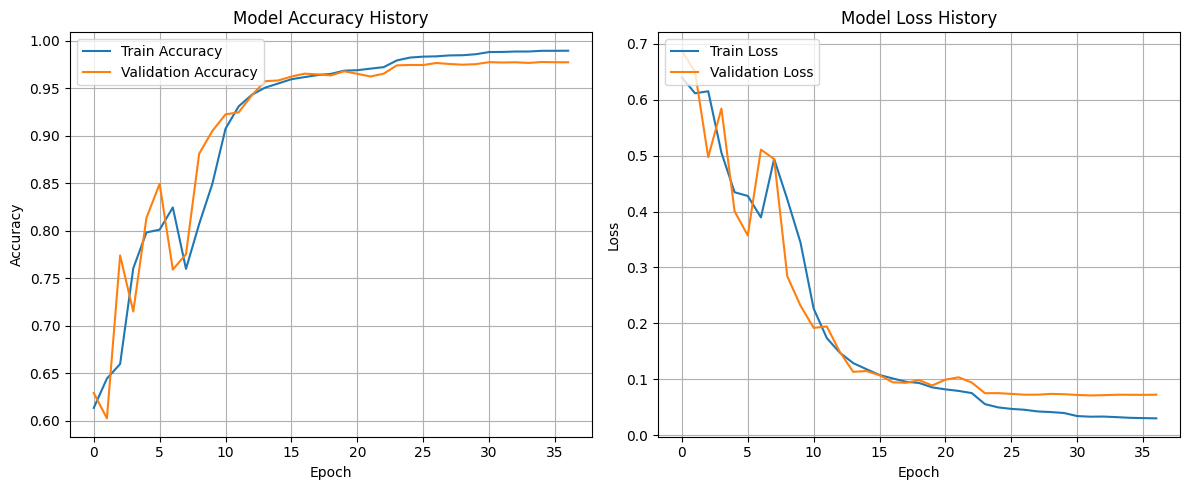

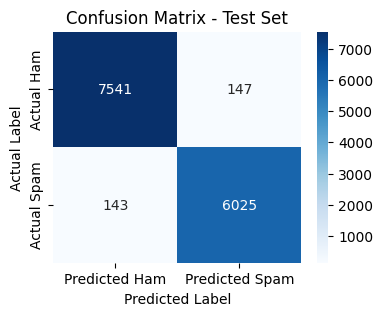


Model Evaluation Complete (PyTorch on XPU/CPU). 📊

BiLSTM Spam Classifier model saved to: trained_models_pytorch_xpu\bilstm_spam_classifier_xpu.pth 💾


In [9]:
import torch
import torch.nn as nn # For criterion
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- IPEX and Device Configuration (Assumed from Model Building Block) ---
import torch

try:
    import intel_extension_for_pytorch as ipex
    _IPEX_AVAILABLE = True
except ImportError:
    _IPEX_AVAILABLE = False

# Defensive check: define device only if not already defined
if 'device' not in locals():
    if _IPEX_AVAILABLE and hasattr(torch, 'xpu') and torch.xpu.is_available():
        device = torch.device("xpu")
        print(f"Using Intel XPU via IPEX for training. Device: {device} 🚀")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using NVIDIA CUDA for training. Device: {device} ⚡")
    else:
        device = torch.device("cpu")
        print("No GPU available. Falling back to CPU. ⚠️")
else:
    print(f"Device already initialized: {device}")

print(f"Confirming device for training: {device} 🚀")


# --- IMPORTANT: Model and DataLoaders (Assumed from previous blocks) ---
# This block assumes:
# 1. 'model' object is instantiated (e.g., BiLSTMSpamClassifier) and has been trained.
# 2. 'test_loader' DataLoader is created.
# 3. 'criterion' (loss function) is defined for consistency in calculating test loss.
# 4. 'history' dictionary (from training block) is available for plotting.
try:
    _ = model
    _ = test_loader
    _ = criterion
    _ = history # From training block
    print("Model, Test DataLoader, Criterion, and Training History confirmed to be available. ✅")
except NameError:
    print("Error: 'model', 'test_loader', 'criterion', or 'history' not found. "
          "Please ensure the model building, data splitting, and model training blocks were executed first. ❌")
    exit()

# -----------------------------------------------------------------------------
## Model Evaluation on Test Set
# -----------------------------------------------------------------------------
print("\n--- Evaluating Model on Test Set (PyTorch on XPU/CPU) ---")

model.eval() # Set model to evaluation mode (crucial for inference)
test_loss = 0.0
all_labels = [] # To store all true labels
all_predictions_prob = [] # To store raw probabilities
all_predictions_binary = [] # To store binary (0 or 1) predictions

with torch.no_grad(): # Disable gradient calculations during testing to save memory and speed up
    for inputs, labels in test_loader:
        # Move inputs and labels to the designated device
        inputs, labels = inputs.to(device), labels.to(device)

        # --- MODIFICATION HERE: Unpack both outputs (probabilities and logits) ---
        probabilities, _ = model(inputs) # Forward pass. We only need probabilities for BCELoss and thresholding.
        # -------------------------------------------------------------------------

        loss = criterion(probabilities, labels) # Calculate loss using probabilities
        test_loss += loss.item() * inputs.size(0)

        # Convert probabilities to binary classes (0 or 1) using a threshold (0.5)
        predicted_classes = (probabilities > 0.5).float()

        # Extend lists with data moved to CPU and converted to NumPy for sklearn metrics
        all_labels.extend(labels.cpu().numpy())
        all_predictions_prob.extend(probabilities.cpu().numpy()) # Store raw probabilities
        all_predictions_binary.extend(predicted_classes.cpu().numpy())

final_test_loss = test_loss / len(test_loader.dataset)
# Convert lists to NumPy arrays for scikit-learn functions
all_labels_np = np.array(all_labels).flatten()
all_predictions_binary_np = np.array(all_predictions_binary).flatten()
# all_predictions_prob_np is already converted to numpy in the loop

# Calculate various metrics
final_test_accuracy = accuracy_score(all_labels_np, all_predictions_binary_np)
precision = precision_score(all_labels_np, all_predictions_binary_np)
recall = recall_score(all_labels_np, all_predictions_binary_np)
f1 = f1_score(all_labels_np, all_predictions_binary_np)
conf_matrix = confusion_matrix(all_labels_np, all_predictions_binary_np)
class_report = classification_report(all_labels_np, all_predictions_binary_np, target_names=['Ham', 'Spam'])

print(f"Test Loss: {final_test_loss:.4f}")
print(f"Test Accuracy: {final_test_accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

print("\nConfusion Matrix (Test Set):\n", conf_matrix)
print("\nClassification Report (Test Set):\n", class_report)

# --- Visualize Training History ---
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Visualize Confusion Matrix ---
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Ham', 'Predicted Spam'],
            yticklabels=['Actual Ham', 'Actual Spam'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nModel Evaluation Complete (PyTorch on XPU/CPU). 📊")

# -----------------------------------------------------------------------------
## Save the Trained PyTorch Model
# -----------------------------------------------------------------------------
MODEL_SAVE_DIR = 'trained_models_pytorch_xpu'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
# Save the model's state_dict (recommended way to save PyTorch models)
# This saves only the learned parameters, not the model architecture.
# To load, you'll need to re-instantiate BiLSTMSpamClassifier and then load this state_dict.
# --- MODIFICATION HERE: Update filename for BiLSTM ---
PYTORCH_MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, 'bilstm_spam_classifier_xpu.pth')
# ----------------------------------------------------

try:
    model.cpu() # Move model to CPU before saving for broader compatibility
    torch.save(model.state_dict(), PYTORCH_MODEL_SAVE_PATH)
    print(f"\nBiLSTM Spam Classifier model saved to: {PYTORCH_MODEL_SAVE_PATH} 💾")
    model.to(device) # Move model back to device if you intend to use it further
except Exception as e:
    print(f"Error saving PyTorch model: {e} ❌")